In [ ]:
!pip install rasterio
!pip install pandas
!pip install geopandas
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install shapely
!pip install -q kaggle

In [ ]:
import os
import glob
import gc
import random

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
from rasterio.transform import Affine

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union, transform

import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Download dataset from Kaggle

In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d isaienkov/deforestation-in-ukraine

# !mkdir dataset
# !unzip deforestation-in-ukraine.zip -d dataset

In [ ]:
# Set the path to your dataset folder
dataset_folder = '/content/dataset'

# Use glob with recursive search to find all .SAFE directories
safe_dirs = glob.glob(os.path.join(dataset_folder, '**', '*.SAFE'), recursive=True)

In [ ]:
safe_dirs[0:5]

['/content/dataset/S2A_MSIL1C_20190427T083601_N0207_R064_T36UXA_20190427T100851/S2A_MSIL1C_20190427T083601_N0207_R064_T36UXA_20190427T100851.SAFE',
 '/content/dataset/S2B_MSIL1C_20180815T084009_N0206_R064_T36UXA_20180815T123155/S2B_MSIL1C_20180815T084009_N0206_R064_T36UXA_20180815T123155.SAFE',
 '/content/dataset/S2A_MSIL1C_20180830T083601_N0206_R064_T36UXA_20180830T105527/S2A_MSIL1C_20180830T083601_N0206_R064_T36UXA_20180830T105527.SAFE',
 '/content/dataset/S2B_MSIL1C_20180904T083549_N0206_R064_T36UXA_20180904T123955/S2B_MSIL1C_20180904T083549_N0206_R064_T36UXA_20180904T123955.SAFE',
 '/content/dataset/S2A_MSIL1C_20180810T083601_N0206_R064_T36UXA_20180810T124435/S2A_MSIL1C_20180810T083601_N0206_R064_T36UXA_20180810T124435.SAFE']

Images with different weather conditions

In [ ]:
def show_raster(path):
    """
    Load and display a raster image from the specified file path using Rasterio.

    Args:
        path (str): The file path to the raster image (e.g., a .jp2 file).

    Returns:
        None: The function displays the raster image using Matplotlib.
    """
    # Open the raster file using Rasterio and read the image data
    with rasterio.open(path, "r", driver="JP2OpenJPEG") as src:
        raster_img = src.read()
        raster_meta = src.meta

    # Reshape the image to a standard image format (height x width x channels)
    raster_img = reshape_as_image(raster_img)

    # Display the image
    plt.figure(figsize=(15, 15))
    plt.imshow(raster_img)

A litle bit of clouds, No snow

In [ ]:
path_1 = "/content/dataset/S2A_MSIL1C_20160621T084012_N0204_R064_T36UYA_20160621T084513/S2A_MSIL1C_20160621T084012_N0204_R064_T36UYA_20160621T084513.SAFE/GRANULE/L1C_T36UYA_A005209_20160621T084513/IMG_DATA/T36UYA_20160621T084012_TCI.jp2"

show_raster(path_1)

A litle bit of clouds, Snow

In [ ]:
path_2 = "/content/dataset/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE/GRANULE/L1C_T36UYA_A003350_20160212T084510/IMG_DATA/T36UYA_20160212T084052_TCI.jp2"

show_raster(path_2)

A lot of clouds, No snow

In [ ]:
path_3 = "/content/dataset/S2A_MSIL1C_20190616T083601_N0207_R064_T36UYA_20190616T105922/S2A_MSIL1C_20190616T083601_N0207_R064_T36UYA_20190616T105922.SAFE/GRANULE/L1C_T36UYA_A020796_20190616T084207/IMG_DATA/T36UYA_20190616T083601_TCI.jp2"

show_raster(path_2)

In [ ]:
def resample_band(src, shape):
    """Resample the raster band to a given shape using bilinear interpolation."""
    return src.read(out_shape=shape, resampling=rasterio.enums.Resampling.bilinear)


# # Resample image to a lower resolution
# def resample_image(image, scale=0.5):
#     """Resample the given image to a lower resolution based on the scale."""
#     new_shape = (int(image.shape[0] * scale), int(image.shape[1] * scale))
#     return cv2.resize(image, new_shape, interpolation=cv2.INTER_LINEAR)


def save_image_as_png(image, band_name, granule_name, output_dir):
    """Save the provided image as a PNG file with an optional colormap for NDVI bands."""
    # Construct the output file path
    output_path = os.path.join(output_dir, band_name, f"{granule_name}_{band_name}.png")

    # Save the image using the appropriate colormap for NDVI, otherwise default
    plt.imsave(output_path, image, cmap='RdYlGn' if band_name == 'NDVI' else None)

    # Print confirmation message
    print(f"Saved {band_name} PNG to {output_path}")


In [ ]:
def compute_ndvi(nir_band, red_band):
    """
    Compute the Normalized Difference Vegetation Index (NDVI) from the NIR and Red bands.

    NDVI is a measure of vegetation health calculated as:
    NDVI = (NIR - Red) / (NIR + Red)
    """
    # Convert the NIR and Red bands to float32 to handle division safely
    nir = nir_band.astype('float32')
    red = red_band.astype('float32')

    # Compute NDVI, avoiding division by zero
    ndvi = np.where(
        (nir + red) == 0.,  # If the sum of NIR and Red is zero
        0,                  # Set NDVI to 0 to avoid division by zero
        (nir - red) / (nir + red)
    )

    return ndvi


In [ ]:
# Delete an image_matching folder if needed
!rm -r /content/image_matching

In [ ]:
# Create the image_matching folder with subdirectories for each band
output_dir = '/content/image_matching'
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, 'TCI'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'NDVI'), exist_ok=True)

In [ ]:
# Images that I decided to experiment on
weather_1 = "/content/dataset/S2A_MSIL1C_20160621T084012_N0204_R064_T36UYA_20160621T084513/S2A_MSIL1C_20160621T084012_N0204_R064_T36UYA_20160621T084513.SAFE"
weather_2 = "/content/dataset/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE"
weather_3 = "/content/dataset/S2A_MSIL1C_20190616T083601_N0207_R064_T36UYA_20190616T105922/S2A_MSIL1C_20190616T083601_N0207_R064_T36UYA_20190616T105922.SAFE"

three_safe_dirs = [weather_1, weather_2, weather_3]

Processing /content/dataset/S2A_MSIL1C_20160621T084012_N0204_R064_T36UYA_20160621T084513/S2A_MSIL1C_20160621T084012_N0204_R064_T36UYA_20160621T084513.SAFE


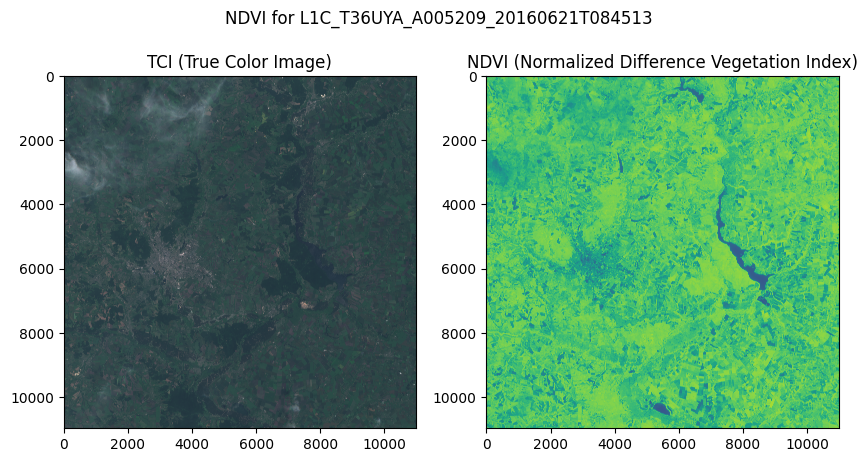

Saved TCI PNG to /content/image_matching/TCI/L1C_T36UYA_A005209_20160621T084513_TCI.png
Saved NDVI PNG to /content/image_matching/NDVI/L1C_T36UYA_A005209_20160621T084513_NDVI.png
Processing /content/dataset/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510/S2A_MSIL1C_20160212T084052_N0201_R064_T36UYA_20160212T084510.SAFE


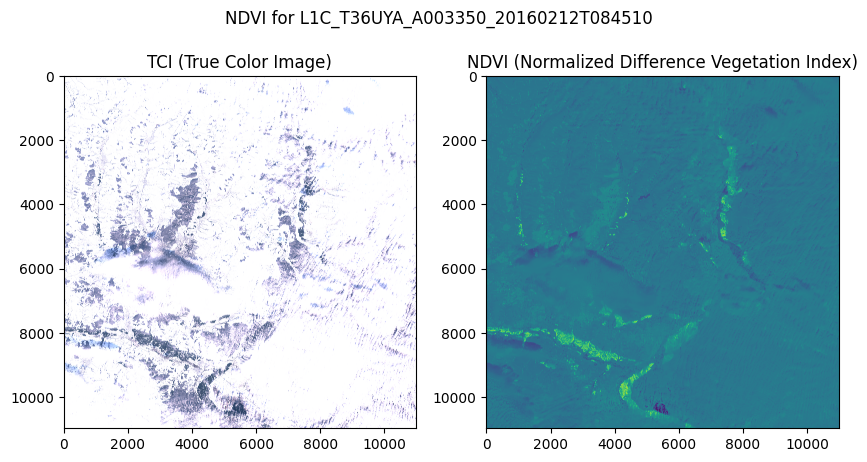

Saved TCI PNG to /content/image_matching/TCI/L1C_T36UYA_A003350_20160212T084510_TCI.png
Saved NDVI PNG to /content/image_matching/NDVI/L1C_T36UYA_A003350_20160212T084510_NDVI.png
Processing /content/dataset/S2A_MSIL1C_20190616T083601_N0207_R064_T36UYA_20190616T105922/S2A_MSIL1C_20190616T083601_N0207_R064_T36UYA_20190616T105922.SAFE


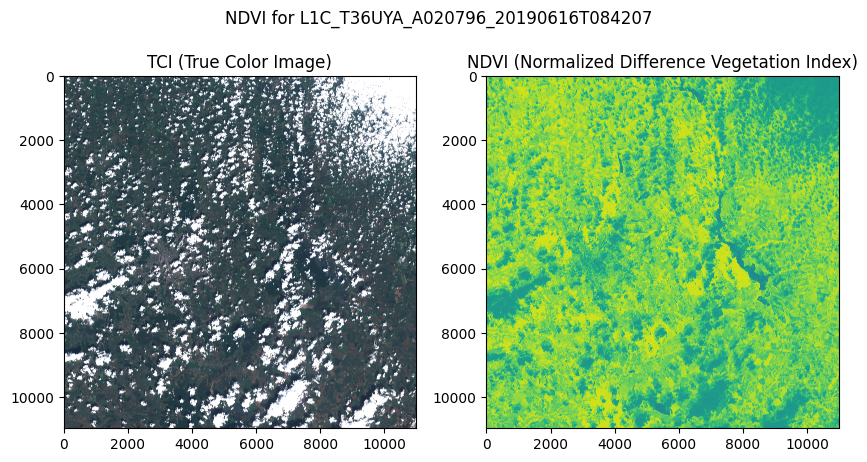

Saved TCI PNG to /content/image_matching/TCI/L1C_T36UYA_A020796_20190616T084207_TCI.png
Saved NDVI PNG to /content/image_matching/NDVI/L1C_T36UYA_A020796_20190616T084207_NDVI.png
Processing completed.


In [ ]:
# Loop through each .SAFE directory
for safe_dir in three_safe_dirs:
    print(f"Processing {safe_dir}")

    # Path to the IMG_DATA folder inside the GRANULE directory
    img_data_dir = os.path.join(safe_dir, 'GRANULE')
    granule_dirs = glob.glob(os.path.join(img_data_dir, '*'))

    for granule_dir in granule_dirs:
        # Path to the image data for the granule
        img_data_path = os.path.join(granule_dir, 'IMG_DATA')

        # Find the required band files (TCI, B04, B08)
        band_files = {
            'TCI': glob.glob(os.path.join(img_data_path, '*_TCI.jp2')),  # True Color Image (RGB)
            'B04': glob.glob(os.path.join(img_data_path, '*_B04.jp2')),  # Red band (B04)
            'B08': glob.glob(os.path.join(img_data_path, '*_B08.jp2')),  # Near Infrared band (B08)
        }

        # Ensure all bands (TCI, B04, B08) are found
        if all(len(band_files[key]) > 0 for key in band_files):
            # Open the bands using Rasterio
            with rasterio.open(band_files['TCI'][0]) as tci_src, \
                 rasterio.open(band_files['B04'][0]) as b04_src, \
                 rasterio.open(band_files['B08'][0]) as b08_src:

                # Read the TCI band (RGB image)
                tci_image = tci_src.read()
                tci_image = reshape_as_image(tci_image)  # Reshape into an RGB format

                # Read the Red (B04) and NIR (B08) bands as single-channel grayscale images
                b04_image = b04_src.read(1)
                b08_image = b08_src.read(1)

                # Resample the Red (B04) and NIR (B08) bands to match the dimensions of the TCI band
                dst_width = tci_src.width
                dst_height = tci_src.height
                b04_resampled = resample_band(b04_src, (b04_src.count, dst_height, dst_width))[0]
                b08_resampled = resample_band(b08_src, (b08_src.count, dst_height, dst_width))[0]

                # Compute the NDVI (Normalized Difference Vegetation Index)
                ndvi_image = compute_ndvi(b08_resampled, b04_resampled)

                # Plot the TCI and NDVI images side by side
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(tci_image)
                plt.title('TCI (True Color Image)')

                plt.subplot(1, 2, 2)
                plt.imshow(ndvi_image, cmap='RdYlGn')
                plt.title('NDVI (Normalized Difference Vegetation Index)')

                plt.suptitle(f'NDVI for {os.path.basename(granule_dir)}')
                plt.show()

                # Save the TCI and NDVI images as PNG files in the specified output directory
                granule_name = os.path.basename(granule_dir)
                save_image_as_png(tci_image, 'TCI', granule_name, output_dir)
                save_image_as_png(ndvi_image, 'NDVI', granule_name, output_dir)

                # Free memory after processing each image set to avoid memory overuse
                del tci_image, b04_resampled, b08_resampled, ndvi_image
                gc.collect()  # Run garbage collection to free up memory

        else:
            print(f"Required bands not found in {img_data_path}")

print("Processing completed.")


Send the folder to a google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

# Define the source folder in Colab (e.g., the folder you want to copy)
source_folder = '/content/image_matching'

# Define the destination folder in Google Drive
destination_folder = '/content/drive/MyDrive/image_matching'

# Copy the entire folder to Google Drive
shutil.copytree(source_folder, destination_folder)

print(f"Folder {source_folder} copied to {destination_folder} successfully.")

Folder /content/image_matching copied to /content/drive/MyDrive/image_matching successfully.
